In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')  # Optional but useful for some tokenizers
nltk.download('wordnet')                     # Optional for lemmatization


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import os
import nltk
import torch
import random
import numpy as np
import torchvision.transforms as transforms
from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from tqdm import tqdm

nltk.download('punkt')

# ---------- Configuration ----------
IMAGE_DIR = "/content/drive/MyDrive/Deep6/Flicker8k_Dataset"
CAPTION_FILE = "/content/drive/MyDrive/Deep6/Flickr8k_text/Flickr8k.token.txt"
TRAIN_IMAGES_FILE = "/content/drive/MyDrive/Deep6/Flickr8k_text/Flickr_8k.trainImages.txt"
EPOCHS = 20
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LEN = 20
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_WORKERS = 2

# ---------- Vocabulary ----------
class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.word2idx = {"<pad>": 0, "<start>": 1, "<end>": 2, "<unk>": 3}
        self.idx2word = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.word_freq = {}
        self.idx = 4

    def build_vocab(self, sentence_list):
        for sentence in sentence_list:
            tokens = nltk.tokenize.word_tokenize(sentence.lower())
            for word in tokens:
                self.word_freq[word] = self.word_freq.get(word, 0) + 1
                if self.word_freq[word] == self.freq_threshold:
                    self.word2idx[word] = self.idx
                    self.idx2word[self.idx] = word
                    self.idx += 1

    def numericalize(self, text):
        tokens = nltk.tokenize.word_tokenize(text.lower())
        return [self.word2idx.get(word, self.word2idx["<unk>"]) for word in tokens]

# ---------- Dataset ----------
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, image_list_file, vocab, transform=None):
        with open(captions_file, 'r') as f:
            lines = f.readlines()

        with open(image_list_file, 'r') as f:
            train_images = set(line.strip() for line in f)

        self.img_captions = {}
        self.data = []
        for line in lines:
            img_id, caption = line.strip().split('\t')
            img_id = img_id[:-2]
            if img_id in train_images:
                caption = caption.lower()
                if img_id not in self.img_captions:
                    self.img_captions[img_id] = []
                self.img_captions[img_id].append(caption)
                self.data.append((img_id, caption))

        self.vocab = vocab
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_id, caption = self.data[idx]
        img_path = os.path.join(self.root_dir, img_id)
        image = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        tokens = [1] + self.vocab.numericalize(caption)[:MAX_LEN-2] + [2]
        caption_tensor = torch.tensor(tokens)
        return image, caption_tensor

def collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images, 0)
    lengths = [len(c) for c in captions]
    padded = nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=0)
    return images, padded, lengths

# ---------- Encoder ----------
class EncoderCNN(nn.Module):
    def __init__(self, encoded_size=EMBED_SIZE):
        super().__init__()
        resnet = resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(resnet.fc.in_features, encoded_size)

    def forward(self, images):
        with torch.no_grad():
            features = self.features(images).squeeze()
        return self.fc(features)

# ---------- Decoder ----------
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.init_h = nn.Linear(embed_size, hidden_size)
        self.init_c = nn.Linear(embed_size, hidden_size)

    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)  # [B, T, E]
        packed = nn.utils.rnn.pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False)

        h0 = self.init_h(features).unsqueeze(0)  # [1, B, H]
        c0 = self.init_c(features).unsqueeze(0)  # [1, B, H]

        hiddens, _ = self.lstm(packed, (h0, c0))
        outputs = self.linear(hiddens.data)
        return outputs

# ---------- Training ----------
def train():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,) * 3, (0.5,) * 3)
    ])

    print("Building dataset and vocab...")
    all_captions = [line.strip().split('\t')[1].lower() for line in open(CAPTION_FILE)]
    vocab = Vocabulary()
    vocab.build_vocab(all_captions)

    dataset = FlickrDataset(IMAGE_DIR, CAPTION_FILE, TRAIN_IMAGES_FILE, vocab, transform)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=NUM_WORKERS)

    encoder = EncoderCNN().to(DEVICE)
    decoder = DecoderRNN(EMBED_SIZE, HIDDEN_SIZE, len(vocab.word2idx)).to(DEVICE)

    criterion = nn.CrossEntropyLoss(ignore_index=0)
    params = list(decoder.parameters()) + list(encoder.fc.parameters())
    optimizer = torch.optim.Adam(params, lr=1e-3)

    print("Starting training...")
    for epoch in range(EPOCHS):
        encoder.train()
        decoder.train()
        total_loss = 0

        for images, captions, lengths in tqdm(loader):
            images, captions = images.to(DEVICE), captions.to(DEVICE)

            features = encoder(images)

            inputs = captions[:, :-1]
            targets = captions[:, 1:]
            input_lengths = [l - 1 for l in lengths]

            outputs = decoder(features, inputs, input_lengths)

            packed_targets = nn.utils.rnn.pack_padded_sequence(targets, input_lengths, batch_first=True, enforce_sorted=False).data

            loss = criterion(outputs, packed_targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss / len(loader):.4f}")

    torch.save({'encoder': encoder.state_dict(), 'decoder': decoder.state_dict(), 'vocab': vocab.word2idx}, "caption.pth")
    print("Model saved!")

# ---------- Run ----------
if __name__ == "__main__":
    train()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Building dataset and vocab...
Starting training...


100%|██████████| 938/938 [03:44<00:00,  4.18it/s]


Epoch 1, Loss: 3.3817


100%|██████████| 938/938 [03:44<00:00,  4.18it/s]


Epoch 2, Loss: 2.7256


100%|██████████| 938/938 [03:50<00:00,  4.07it/s]


Epoch 3, Loss: 2.4721


100%|██████████| 938/938 [03:47<00:00,  4.12it/s]


Epoch 4, Loss: 2.2842


100%|██████████| 938/938 [03:46<00:00,  4.14it/s]


Epoch 5, Loss: 2.1231


100%|██████████| 938/938 [03:47<00:00,  4.13it/s]


Epoch 6, Loss: 1.9718


100%|██████████| 938/938 [03:47<00:00,  4.12it/s]


Epoch 7, Loss: 1.8349


100%|██████████| 938/938 [03:46<00:00,  4.14it/s]


Epoch 8, Loss: 1.7119


100%|██████████| 938/938 [03:47<00:00,  4.12it/s]


Epoch 9, Loss: 1.6014


100%|██████████| 938/938 [03:48<00:00,  4.10it/s]


Epoch 10, Loss: 1.4993


100%|██████████| 938/938 [03:46<00:00,  4.15it/s]


Epoch 11, Loss: 1.4071


100%|██████████| 938/938 [03:48<00:00,  4.11it/s]


Epoch 12, Loss: 1.3269


100%|██████████| 938/938 [03:46<00:00,  4.14it/s]


Epoch 13, Loss: 1.2545


100%|██████████| 938/938 [03:45<00:00,  4.16it/s]


Epoch 14, Loss: 1.1884


100%|██████████| 938/938 [03:52<00:00,  4.04it/s]


Epoch 15, Loss: 1.1360


100%|██████████| 938/938 [03:47<00:00,  4.12it/s]


Epoch 16, Loss: 1.0839


100%|██████████| 938/938 [03:46<00:00,  4.15it/s]


Epoch 17, Loss: 1.0369


100%|██████████| 938/938 [03:48<00:00,  4.11it/s]


Epoch 18, Loss: 0.9988


100%|██████████| 938/938 [03:47<00:00,  4.12it/s]


Epoch 19, Loss: 0.9603


100%|██████████| 938/938 [03:47<00:00,  4.12it/s]


Epoch 20, Loss: 0.9313
Model saved!


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Recreate classes from training (copy these if in separate file)
class EncoderCNN(nn.Module):
    def __init__(self, encoded_size=256):
        super().__init__()
        resnet = resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(resnet.fc.in_features, encoded_size)

    def forward(self, images):
        with torch.no_grad():
            features = self.features(images).squeeze()
        return self.fc(features)

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.init_h = nn.Linear(embed_size, hidden_size)
        self.init_c = nn.Linear(embed_size, hidden_size)

    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        packed = nn.utils.rnn.pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False)

        h0 = self.init_h(features).unsqueeze(0)
        c0 = self.init_c(features).unsqueeze(0)

        hiddens, _ = self.lstm(packed, (h0, c0))
        outputs = self.linear(hiddens.data)
        return outputs
def show_image_with_caption(image_path, caption):
        image = Image.open(image_path).convert("RGB")
        plt.imshow(image)
        plt.axis('off')
        plt.title(caption, fontsize=14)
        plt.show()




In [ ]:
# Load model data
checkpoint = torch.load("caption.pth", map_location=DEVICE)

# Rebuild vocab from word2idx
word2idx = checkpoint['vocab']
idx2word = {idx: word for word, idx in word2idx.items()}

# Rebuild encoder and decoder
encoder = EncoderCNN().to(DEVICE)
decoder = DecoderRNN(EMBED_SIZE, HIDDEN_SIZE, len(word2idx)).to(DEVICE)

# Load weights
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])

encoder.eval()
decoder.eval()


DecoderRNN(
  (embed): Embedding(3005, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=3005, bias=True)
  (init_h): Linear(in_features=256, out_features=512, bias=True)
  (init_c): Linear(in_features=256, out_features=512, bias=True)
)

In [ ]:
def generate_caption(image_path, encoder, decoder, word2idx, idx2word, max_len=20):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,) * 3, (0.5,) * 3)
    ])

    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        features = encoder(image)
        inputs = torch.tensor([[word2idx["<start>"]]], device=DEVICE)
        caption = []

        hidden = (
            decoder.init_h(features).unsqueeze(0).unsqueeze(1),  # Shape: [1, 1, hidden_size]
            decoder.init_c(features).unsqueeze(0).unsqueeze(1)
)


        for _ in range(max_len):
            embeddings = decoder.embed(inputs)
            output, hidden = decoder.lstm(embeddings, hidden)
            output = decoder.linear(output.squeeze(1))
            predicted = output.argmax(1)
            word = idx2word[predicted.item()]
            if word == "<end>":
                break
            caption.append(word)
            inputs = predicted.unsqueeze(1)

    return ' '.join(caption)


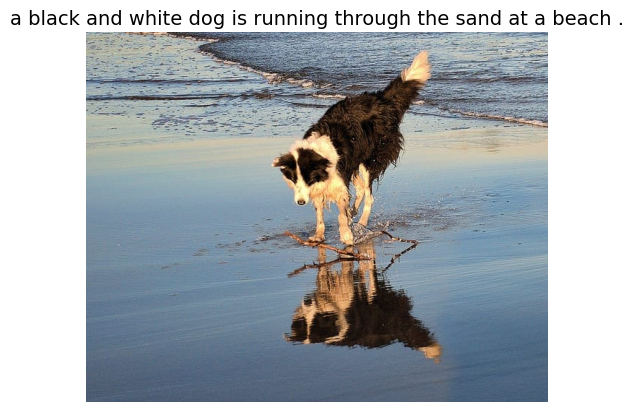

In [ ]:

image_path = "/content/drive/MyDrive/cap.jpg"
caption = generate_caption(image_path, encoder, decoder, word2idx, idx2word)

# Show image with the caption
show_image_with_caption(image_path, caption)



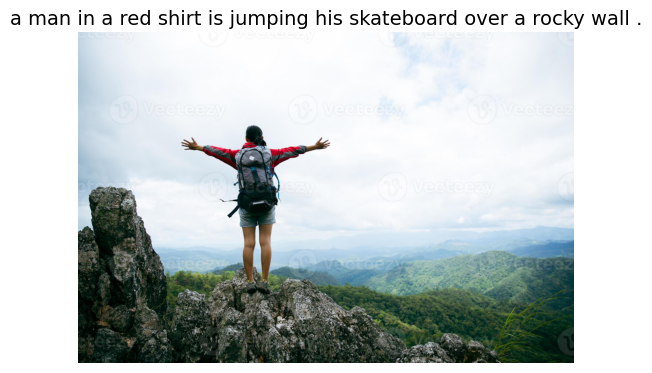

In [ ]:
image_path = "/content/drive/MyDrive/moun.jpg"
caption = generate_caption(image_path, encoder, decoder, word2idx, idx2word)

# Show image with the caption
show_image_with_caption(image_path, caption)